In [132]:
import math 
import pandas as pd 
import torch 
from torch import nn 
from d2l import torch as d2l

In [133]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算 `X` 的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X)  )


layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


## 1. 基于位置的前馈网络

In [134]:
class PositionWiseFFN( nn.Module ):
    ''' 输入x( 批次 ， 时间步或者序列长度  ， 特征维度或者隐藏单元数 ) '''
    def __init__( self , ffn_num_input , ffn_num_hiddens , ffn_num_outputs  , **kwargs ):
        super().__init__(**kwargs)
        self.dense1 = nn.Linear( ffn_num_input , ffn_num_hiddens )
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear( ffn_num_hiddens , ffn_num_outputs )
    
    def forward( self , X ):
        return self.dense2( self.relu( self.dense1( X ) ) )


In [135]:
test_tensor = torch.ones( ( 2 ,3 ,4 ) )
ffn = PositionWiseFFN( 4, 4 , 8 )
ffn( test_tensor ).shape

torch.Size([2, 3, 8])

In [136]:
#但是我们实际上是要把输入的位置维度映射到相同的位置维度，保证输入和输出相同，这么做的原因我想可能是为网络加入非线性
ffn = PositionWiseFFN(  4  , 4 , 4  )
ffn( test_tensor ).shape

torch.Size([2, 3, 4])

## 2. 残差连接和层归一化AddNorm

In [137]:
class AddNorm( nn.Module ):
    def __init__( self , normlized_shape , dropout , **kwargs ):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout( dropout )
        self.layer_norm = nn.LayerNorm( normlized_shape )
    def forward( self , X  ,Y  ):#X一般是输入，Y是当前网络层的输出
        return self.layer_norm( self.dropout( Y ) + X )

In [138]:
add_norm = AddNorm( [3 ,4] , 0.5 )
add_norm( test_tensor , test_tensor  ).shape

torch.Size([2, 3, 4])

## 编码器

In [139]:
# 现在我们实现transformer编码器的单元块,每个单元块要保证输入和输出的shape一致,其中我们有一个加入残差连接和层归一化的多头注意力，一个
# 同样加入残差和层归一化的基于位置的前馈网络。
class EncoderBlock( nn.Module ):
    ''' 首先我们应该清楚要实现自注意力，要保证多头注意力中的q,k,v保持一致，我们应该有这个tips在心里，但是d2l代码还是给分开写了'''
    def __init__(self , query_size , key_size , value_size , num_hiddens,  norm_shape , 
                ffn_num_input , ffn_num_hiddens ,  num_heads  , dropout , use_bias = False,  **kwargs ):
        super().__init__( **kwargs )
        #注意的是这里使用的是遮蔽点击注意力机制
        self.attention = d2l.MultiHeadAttention( key_size , query_size , value_size , num_hiddens ,num_heads , dropout , use_bias )
        self.addnorm1 = AddNorm( norm_shape , dropout )
        self.ffn = PositionWiseFFN( ffn_num_input , ffn_num_hiddens , num_hiddens )
        self.addnorm2 = AddNorm( norm_shape , dropout )
    
    def forward( self , X , valid_lens ):
        #记住valid_lens是遮蔽从当前位置向后所有的元素。比如一个分数向量是[1 ,2 ,3 ],valid_len为[1]，就是遮蔽从位置1向后的所有的元素
        #那么分数向量就是[1, 0 ,0 ]
        Y = self.addnorm1( X , self.attention( X , X , X , valid_lens ) )
        return self.addnorm2( Y , self.ffn( Y ) )#( batch_size , query_size , num_hiddens )

In [140]:
X = torch.ones( 2 , 100 , 24 )
valid_lens = torch.tensor( [3 ,2 ] )
encoder_block = EncoderBlock( 24 , 24 , 24 , 24 ,[100,24] , 24 , 48 , 8 ,  0.5  )
encoder_block( X  , valid_lens ).shape

torch.Size([2, 100, 24])

In [141]:
class TransformerEncoder( d2l.Encoder ):
    def __init__( self ,vocab_size , query_szie , key_size , value_size , num_hiddens , norm_shape , ffn_numm_input , ffn_num_hiddens,  
                   num_heads , num_layers , dropout , use_bias = False , **kwargs  ):
        super().__init__( )
        self.hiddens = num_hiddens
        self.embedding = nn.Embedding( vocab_size , num_hiddens )#这里注意一下使用了embedding将词表维度映射到num_hiddens维
        self.pos_encoding = d2l.PositionalEncoding( num_hiddens , dropout )
        self.blks = nn.Sequential()
        for i in range( num_layers ):
            #这个方法显然就是将当前网络加入到顺序层当中(name: str, module: Module | None)
            self.blks.add_module( 'block'+str(i) , 
                EncoderBlock( query_szie , key_size , value_size , num_hiddens , norm_shape , 
                                ffn_numm_input , ffn_num_hiddens , num_heads , dropout , use_bias  )    )


    def forward( self , X , valid_lens , *args ):
        '''在大脑中回忆起整个网络的细节：输入(batch_size , num_steps , vocab_size )--->embedding--->PositionalEncoding
            --->( AddNorm( MultiHeadAttention )--->AddNorm( PositionWiseFFN ) ) * N --->hidden_state '''
        # 因为位置编码值在 -1 和 1 之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding( self.embedding( X ) * math.sqrt( self.hiddens ) )
        #这里将权值进行保存
        self.attention_weights  = [None]*len( self.blks )
        for i,blk in enumerate( self.blks ):
            X = blk( X , valid_lens )
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X 

In [142]:
encoder = TransformerEncoder( 200 , 24 , 24 , 24 , 24 , [ 100 , 24 ] , 24 ,  ffn_num_hiddens= 48 , num_heads=8 ,  num_layers=2 , dropout=0.5  )
#这里是词表维度为200，实际上输入为( 2 ,100 )的话，我们使用独热编码为( 2 , 100 , 200 ),但是我们实际上使用了embedding，将200维的信息映射到了24维，起到了
#降维的效果，当然，这只是embedding的一个优点而已，另外一个分布的优点也得记住
encoder.eval()
encoder(torch.ones( ( 2 , 100 ) , dtype=torch.long ) , valid_lens ).shape

torch.Size([2, 100, 24])

## 解码器

In [143]:
class DecoderBlock( nn.Module ):
    def __init__( self , query_size , key_size , value_size , num_hiddens , norm_shape , ffn_num_input , 
                ffn_num_hiddens , num_heads , dropout , i , **kwargs ):
        super().__init__(**kwargs)
        self.i = i #这个i的意思表示在第几个DecoderBlock里
        self.attention1 = d2l.MultiHeadAttention( 
            key_size , query_size , value_size , num_hiddens , num_heads , dropout
        )
        self.addnorm1 = AddNorm(norm_shape , dropout )
        self.attention2 = d2l.MultiHeadAttention(
            key_size , query_size , value_size , num_hiddens  , num_heads , dropout
        )
        self.addnorm2 = AddNorm( norm_shape , dropout )
        self.ffn = PositionWiseFFN( ffn_num_input , ffn_num_hiddens , num_hiddens )
        self.addnorm3 = AddNorm( norm_shape , dropout )

    def forward( self , X , state ):
        #state为一个三元列表
        enc_outputs , enc_valid_lens = state[0] , state[1]        
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:#如果是训练阶段，kv就是自己。注意：训练的过程我们是把完整的一句话传入进去，而在预测的过程中我们是逐个词元逐个词元
                                    #按照时间步顺序进行传递
            key_values = X
        else:#如果是预测阶段，我们要将以往过去的词元拼接起来，还有一点需要注意，注意力机制当中，时间步是在轴1上的
            key_values = torch.cat( (state[2][self.i] , X ) , axis = 1 )
            # print( key_values.shape )
        state[2][self.i] = key_values#我们知道：输入shape为多大，经过一个block之后的shape就为多大。假设当前为
        if self.training:#如果是在训练的话,也就是说model.train()的时候，self.training是True,model.eval()的时候self.training就是False
            batch_size , num_steps , _ = X.shape
            
            # dec_valid_lens的开头：( batch_size , num_steps )
            # 其中每一行是[1,2 ,.....,num_steps]
            #这一段我们可以参考‘注意力评分函数’这一节，传入的是二维张量的话，就是对单个批次的数据进行遮蔽。这里就是将qv乘得的矩阵进行遮蔽
            #将未来的信息进行遮蔽，只保留当前时间步与过去时间步的注意力关系。之后我们进行softmax得到的进行当前时间步与过去时间步的注意力分数
            #这个注意力分数与values乘得的张量就是遮蔽注意力机制
            dec_valid_lens = torch.arange( 1 , num_steps+1  , device=X.device ).repeat( batch_size , 1 )
        else:#预测过程之所以不需要遮蔽，就是因为训练过程我们是将整段话传入进去，预测过程我们是把decode_block的输出作为输入，一个一个词元进行拼接，
             #如果使用逐时间步拼接的方式，那么是根本看不到未来的词元(信息)的
            dec_valid_lens = None
        #自注意力机制,带遮蔽
        X2 = self.attention1( X , key_values , key_values , dec_valid_lens )
        Y = self.addnorm1( X , X2 )
        #encoder-decoder attention
        #enc_outputs的开头：( batch_size , num_steps , num_hiddens )
        Y2 = self.attention2( Y , enc_outputs , enc_outputs , enc_valid_lens )
        Z = self.addnorm2( Y , Y2 )
        return self.addnorm3( Z , self.ffn( Z ) )  , state
        #假如当前是预测阶段，我们全部输入语句为“这是一只猫啊”，假设当前不看batch，当前时间步的输入的X为[是].shape=( 1,5 )，
        #那么通过拼接过往信息的张量为[<begin> , 这 ].shape = (2 , 5 ), 也就是说X.shape=(1,5),key_values.shape = (2 , 5 ):
        #1. Q*k的转置-----> (1,5 )*( 5 ,2 ) = (1 ,2 )
        #2. softmax当前矩阵，并且我们发现不需要Mask,因为当前输入的X不包含未来的信息
        #3. 与values(2,5)相乘----->( 1,2  )*(2,5)---->得到了当前时间步与过去全部时间步的注意力机制( 1,5 )
        #4. 之后拿着这个矩阵(Q)与编码矩阵(K,V)(6,5)进行attention----->( 1 , 5 )*(5,6 )-----*v(6 ,5 )---->(1 , 5 )
        #5. 经过ffn之后我们将线性变换的输入设置为与num_hiddens一致，最后得到的就是(1 , 5 ),这个张量去查询词汇表可以得到当前词元[一]
        #6. 将当前词元[一]作为下一个时间步的输入，并且将[一]与原来的词元拼接得到key_value( 3 ,5 ),重复第一步。

In [144]:
decoder_blk = DecoderBlock( 24 , 24 , 24 , 24 , [100 , 24] , 24 , 48 , 8 , 0.5 , 0 )
decoder_blk.eval()
X = torch.ones( ( 2 , 100 , 24 ) )
state = [ encoder_block( X , valid_lens ),  valid_lens , [torch.randn( 2, 100 , 24 )] ]
decoder_blk( X , state )
result = decoder_blk( X , state )
print(result[0].shape ,  state[2][0].shape ) #我们可以看到经过两次传递(模拟一次100个时间步输入的时候两个decoder_block的过程)，假设原来的stat[2]当中有值，
                                             #我们会累加过去注意力机制的kv，我估计这样可以看到更多信息

torch.Size([2, 100, 24]) torch.Size([2, 300, 24])


In [145]:
torch.arange( 1, 10 + 1, device=d2l.try_gpu()).repeat(2, 1)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]], device='cuda:0')

In [146]:
class TransformerDecoder( d2l.AttentionDecoder ):
    def __init__( self , vocab_size ,  query_size , key_size ,value_size , num_hiddens , 
                norm_shape , ffn_num_input , ffn_num_hiddens , num_heads , num_layers , dropout , **kwargs  ):
        super().__init__( **kwargs )
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding( vocab_size , num_hiddens )
        self.pos_encoding = d2l.PositionalEncoding( num_hiddens , dropout )
        self.blks = nn.Sequential()
        for i in range( num_layers ):#堆叠Decoder_block
            self.blks.add_module(  "block"+str( i ) , 
                        DecoderBlock( query_size , key_size , value_size , num_hiddens , norm_shape , ffn_num_input , ffn_num_hiddens , 
                                        num_heads , dropout , i )#注意一下i的意思：第几个DecoderBlock
            )
        self.dense = nn.Linear( num_hiddens , vocab_size )#重新映射到词汇表大小当中，方便从词汇表当中提取词汇

    def init_state( self , enc_outputs , enc_valid_lens , *args ):#这段函数的调用还是要参考EncoderDecoder的类方法当中，参看‘编码器和解码器.ipynb’
        #返回的三元列表：[ 编码器输出( 隐藏状态信息 ) , 编码可用信息 ， 解码器每一个block的注意力参数 ]
        return [ enc_outputs , enc_valid_lens , [None] * self.num_layers ]

    def forward( self , X , state ):
        X = self.pos_encoding( self.embedding( X )*math.sqrt( self.num_hiddens ) )
        self._attention_weights = [ [None]*len( self.blks ) for _ in range( 2 )]#第一个存储MaskMutleHeadAttention的权值，第二个存储EncoderDecoderAttenion的权值
        for i,blk in enumerate( self.blks ):
            X,state = blk( X , state )
            #遮蔽注意力机制
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights#这个attention_weights是每个decoder_block的点积注意力中的权值参数
            #Encoder-Decoder注意力机制
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense( X ) ,state
    
    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.032, 3629.8 tokens/sec on cuda:0


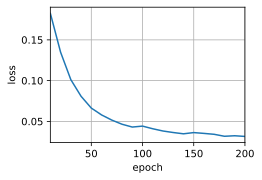

In [147]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab),  query_size,key_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), query_size, key_size,  value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


In [148]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')


go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
